**Simulated Annealing for the predator-prey model**

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint


from scipy.optimize import minimize
import scipy.stats as stat

import ast
import csv

import warnings
# Ignore the ODEintWarning
warnings.filterwarnings("ignore", category=UserWarning, module="scipy.integrate._odepack")

In [3]:
# import data 
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")
t = np.array(df["t"])
x = df["x"]
y = df["y"]

data = df

In [4]:
def lotka_volterra(init, t, alpha, beta, delta, gamma):
    x, y = init
    dxdt = alpha * x - beta * x * y 
    dydt = delta * x * y - gamma * y
    return dxdt, dydt

def abs_residual(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    x_and_y = np.vstack((x,y)).T

    t_data = np.array(data['t'],dtype=float)
    
    y0 = [x[0], y[0]]       
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    return np.linalg.norm(model - x_and_y)**2

def loss_function_res(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    t_data = np.array(data['t'],dtype=float)

    y0 = [x[0], y[0]]
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    loss = 0
    for i in range(len(t)):
        x_data = x[i]
        x_model = model[i,0]

        y_data = y[i]
        y_model = model[i,1]

        res = (x_data - x_model)**2 + (y_data - y_model)**2
        loss += res
    return loss

In [5]:
def simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, data):
    """"
    Performs simulated annealing to find global optimal values.
    init_guess = initial guess (array of real numbers, indicating alpha, beta, delta, gamma, x0 and y0)
    n_iterations = number of iterations to be performed
    std = standard deviation of the normal distribution that determines new possible solutions (step size)
    min_function = objective function (to be minimized)
    T_start = starting temperature for the cooling schedule
    a, b = variables for the cooling schedule
    data = the data to be fitted

    Returns the final solution and the fitness value of that solution
    """

    prev_sol = init_guess
    T = T_start
    
    for n in range(n_iterations):
        # create a new solution
        new_sol = prev_sol + np.random.normal(0, step, size=len(prev_sol))

        # determine whether new_sol is accepted 
        u = np.random.uniform()

        fit_new_sol = min_function(new_sol,data)
        fit_prev_sol = min_function(prev_sol,data)

        # use Boltzman distribution
        if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1): 
            prev_sol = new_sol
        
        # decrease the temperature
        n += 1
        T = a/np.log(n + b)

    return prev_sol, min_function(prev_sol,data)

In [6]:
def plot_fit(params, df):
    alpha = params[0]
    beta = params[1]
    delta = params[2]
    gamma = params[3]

    y0 = [x[0], y[0]]
     
    time = np.array(df['t'])
    t = np.linspace(time[0], time[-1], 1000)

    output = odeint(lotka_volterra, y0, t, args=(alpha, beta, delta, gamma))

    # Prey population separate
    plt.plot(t,output[:,0], color="r", label = 'Prey')
    plt.scatter(df["t"], df["x"], color = 'r', s = 5)

    plt.legend(fontsize = 15, loc = 'upper right')
    plt.ylabel("Population size", fontsize = 15)
    plt.xlabel("Time", fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.grid()

    plt.show()

    # Predator population separate
    plt.plot(t,output[:,1], color="b", label = 'Predator')
    plt.scatter(df["t"], df["y"], color = 'b', s = 5)

    plt.legend(fontsize = 15, loc = 'upper right')
    plt.ylabel("Population size", fontsize = 15)
    plt.xlabel("Time", fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.grid()

    plt.show()

    # Both populations together

    plt.plot(t,output[:,0], color="r")
    plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'Prey')
    plt.plot(t,output[:,1], color="b")
    plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'Predator')
    
    plt.legend(fontsize = 15)
    plt.ylabel("Population size", fontsize = 15)
    plt.xlabel("Time", fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.grid()

    plt.show()


In [18]:
np.random.seed(5)

init_guess = np.random.uniform(-1,1,4)
n_iterations = 13000
std = 0.5
min_function = abs_residual
T_start = 20
a = 3
b = 10

params, err = simulated_annealing(init_guess, n_iterations, std, min_function, T_start, a, b, data)

C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_19972\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


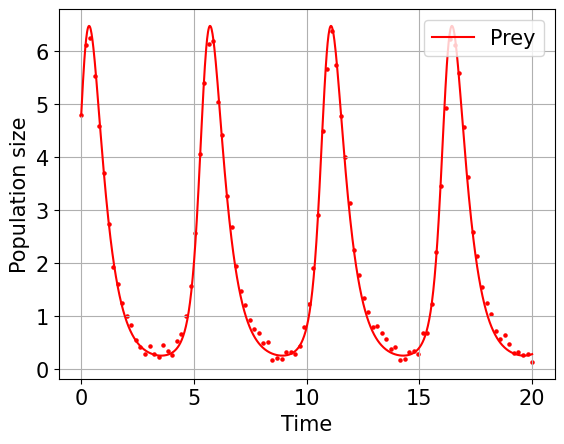

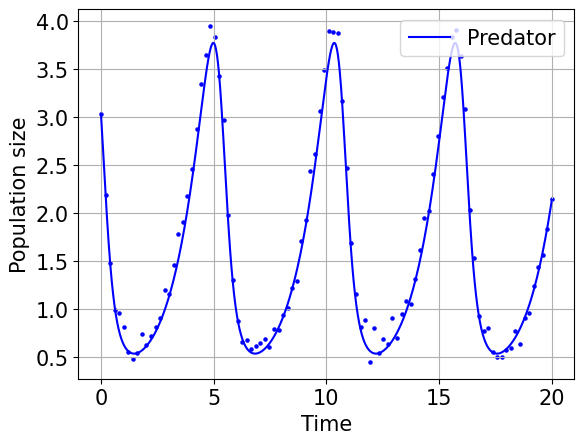

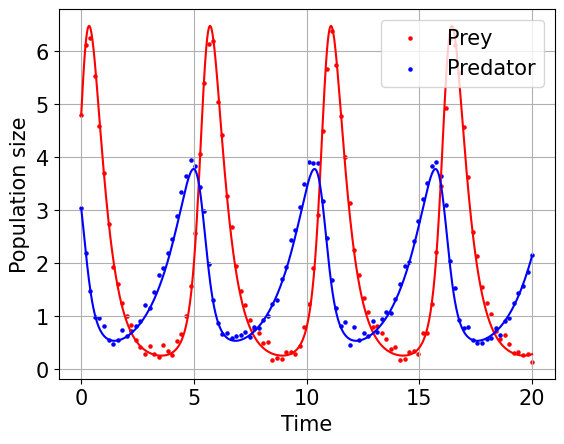

In [19]:
plot_fit(params, df)

**Tuning**

In [7]:
def multi_runs(runs, init_guess, n_iterations, step, min_function, T_start, a, b, data):
    """
    Runs the simulated annealing algorithm multiple times, with random initial guess.
    Returns:
    err_temp = list of all errors (determined with min_function)
    best_sol = solution with lowest residual over all runs
    err_best = residual of best solution
    """
    err_temp = []
    for _ in range(runs):
        init_guess = np.random.uniform(0,1,4)
        params, err = simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, data)
        err_temp.append(err)

        if err < float('inf'):
            best_sol = params
            err_best = err
    return err_temp, best_sol, err_best

In [9]:
# Parameter tuning for step size

n_iterations = 1300
min_function = loss_function_res
T_start = 2
a = 3
b = 10
data = df

step_range = np.arange(0.1,2,0.2)
runs = 30

err_list = []
std_list = []
best_err_so_far = float('inf')

for step in step_range:
    print(step)

    err_temp, best_sol, err_best = multi_runs(runs, init_guess, n_iterations, step, min_function, T_start, a, b, data)

    # save overall best solution and its step size
    if err_best < best_err_so_far:
        best_err_so_far = err_best
        best_sol_total = best_sol
        best_step = step

    err_list.append(np.mean(err_temp))
    std_list.append(np.std(err_temp))

0.1


/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_3802/3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1700092158579D+02   r2 =  0.1424775450140D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1700092158579D+02   r2 =  0.1424775450140D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1700092158579D+02   r2 =  0.1179689266331D-14
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1700092158579D+02   r2 =  0.1179689266331D-14
 lsoda--  warning..internal t (=r1) 

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_3802/3544330308.py:37: RuntimeWarning: overflow encountered in scalar power
  res = (x_data - x_model)**2 + (y_data - y_model)**2


 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1015851522913D+02   r2 =  0.7355746303609D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1015851522913D+02   r2 =  0.7355746303609D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1015851522913D+02   r2 =  0.7355746303609D-15
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1015851522913D+02   r2 =  0.7355746303609D-15
 lsoda--  warning..internal t (=r1) 

In [10]:
print(f"best parameter values found during tuning: {best_sol_total}")
print(f"minimal error value: {best_err_so_far} with step size {best_step}")

best parameter values found during tuning: [-1.16180766 -0.84126499 -0.74661181 -1.57834783]
minimal error value: 33.60679365465331 with step size 1.1000000000000003


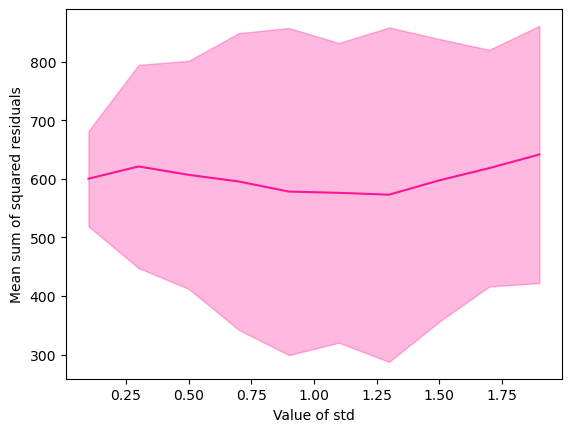

In [11]:
plt.plot(step_range, err_list, color = 'deeppink')
plt.fill_between(step_range, np.array(err_list)-np.array(std_list), np.array(err_list)+np.array(std_list), color = 'deeppink', alpha = 0.3)
plt.xlabel('Value of std')
plt.ylabel('Mean sum of squared residuals')
plt.show()

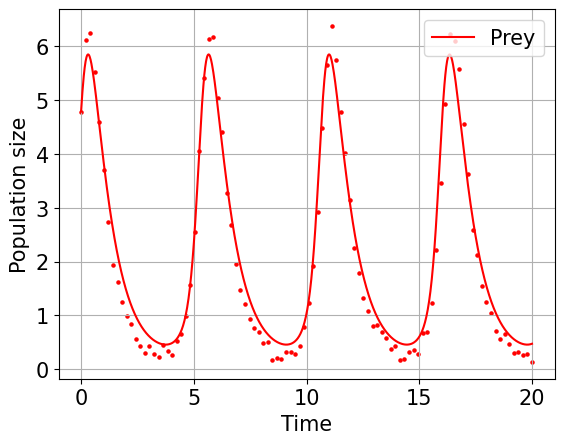

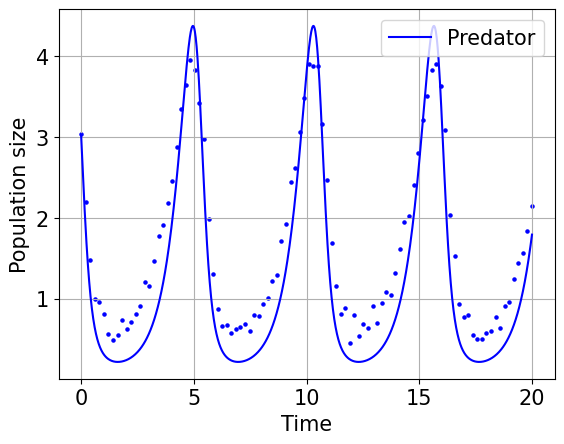

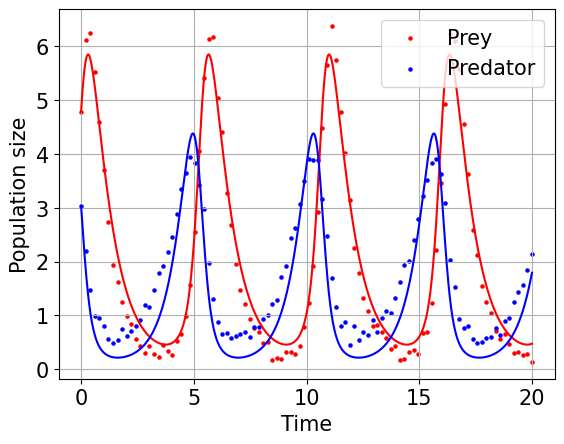

In [20]:
# Plot the best solution

plot_fit(best_sol_total,data)

**3D plot with the amount of runs vs. step size**

**Stochastic hill climbing**

Chooses at random from uphill moves (steepness determines probability of selection)

In [7]:
def stoch_hill_climb(init_guess, std, min_function, data, n_iterations):
    prev_sol = init_guess

    for _ in range(n_iterations):
        # create a new solution
        new_sol = []
        for param in prev_sol:
            new_param = param + np.random.normal(0,std)
            new_sol.append(new_param)

        # determine whether new_sol is accepted
        u = np.random.uniform()
        if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):
            prev_sol = new_sol

    return prev_sol

In [99]:
init_guess = np.ones(4)
std = 0.1
min_function = abs_residual
data = df
n_iterations = 10000

params_shc = stoch_hill_climb(init_guess,std,min_function,data,n_iterations)

/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_54516/2068039739.py:13: RuntimeWarning: overflow encountered in exp
  if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):
/var/folders/wr/_f23fm512gg3qhxthyg30lvc0000gn/T/ipykernel_54516/2068039739.py:13: RuntimeWarning: invalid value encountered in scalar divide
  if u < np.exp(min_function(new_sol,data))/np.exp(min_function(prev_sol,data)):


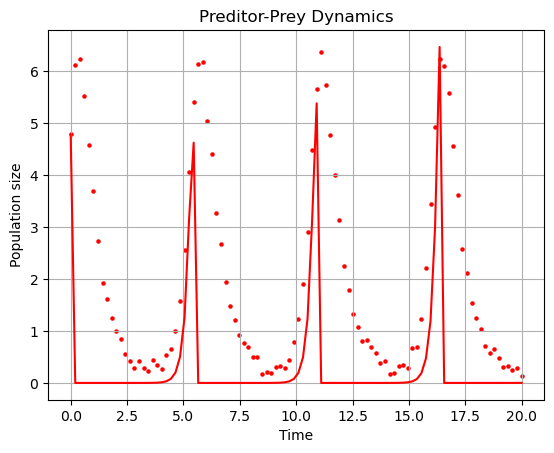

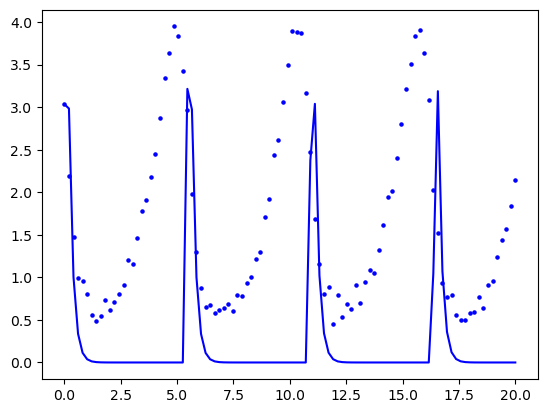

In [100]:
alpha_shc = params_shc[0]
beta_shc = params_shc[1]
delta_shc = params_shc[2]
gamma_shc = params_shc[3]

y0 = [x[0], y[0]]
t = np.linspace(t[0], t[-1], num=len(t))

output_shc = odeint(lotka_volterra, y0, t, args=(alpha_shc, beta_shc, delta_shc, gamma_shc))

plt.title("Preditor-Prey Dynamics")
plt.ylabel("Population size")
plt.xlabel("Time")
plt.grid()

plt.plot(t,output[:,0], color="r")
plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

plt.show()

plt.plot(t,output[:,1], color="b")
plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')

plt.show()

## Time series

subsets: 
1. percentage removed: 0, 10, 20, 30, 40, 50, 60.

2. subsets together: 60 + 40

3. last percentage removed: last 20, 50.

4. peaks predators, peaks prey. (Try to make it 20, 50 points)


### functions

In [317]:
from scipy.optimize import minimize
# Objective functions

def abs_residual(params, data):
    # x = np.array(data['x'],dtype=float)
    # y = np.array(data['y'],dtype=float)
    # x_and_y = np.vstack((x,y)).T

    # t_data = np.array(data['t'],dtype=float)
    
    # y0 = [x[0], y[0]]       
    # model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    # return np.linalg.norm(model - x_and_y)**2
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    t_data = np.array(data['t'],dtype=float)

    y0 = [x[0], y[0]]
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    loss = 0
    for i in range(len(t_data)):
        x_data = x[i]
        x_model = model[i,0]

        y_data = y[i]
        y_model = model[i,1]

        res = abs(x_data - x_model) + abs(y_data - y_model)
        loss += res
    return loss * 1/len(x)


def loss_function_res(params, data):
    x = np.array(data['x'],dtype=float)
    y = np.array(data['y'],dtype=float)
    t_data = np.array(data['t'],dtype=float)

    y0 = [x[0], y[0]]
    model = odeint(lotka_volterra, y0, t_data, args=(params[0], params[1], params[2], params[3]))

    loss = 0
    for i in range(len(t_data)):
        x_data = x[i]
        x_model = model[i,0]

        y_data = y[i]
        y_model = model[i,1]

        res = (x_data - x_model)**2 + (y_data - y_model)**2
        loss += res
    return loss * 1/len(x)

def minimise_loss_function_res(df, params0=None):
    if params0 is None:
        params0 = np.array([-1, -0.5, -0.5, -2])
    output_minimise = minimize(loss_function_res, params0, args=(df))
    # fitted_parameters = output_minimise.x
    # loss = output_minimise.fun
    return output_minimise

def plot_lotka(df, fitted_parameters, extra_df=None):
    t = np.array(df['t'], dtype=float)
    x = np.array(df['x'], dtype=float)
    y = np.array(df['y'], dtype=float)
    alpha_fit, beta_fit, delta_fit, gamma_fit = fitted_parameters
    y0 = [x[0], y[0]]
    t = np.linspace(t[0], t[-1], num=len(t))
    output = odeint(lotka_volterra, y0, t, args=(alpha_fit, beta_fit, delta_fit, gamma_fit))

    plt.title("Preditor-Prey Dynamics")
    plt.ylabel("Population size")
    plt.xlabel("Time")
    plt.grid()

    plt.plot(t,output[:,0], color="r")
    plt.scatter(df["t"], df["x"], color = 'r', s = 5, label = 'x (prey)')

    if extra_df is not None:
        plt.scatter(extra_df["t"], extra_df["x"], color = 'black', s = 5, label = 'x (prey)')

    plt.show()

    plt.plot(t,output[:,1], color="b")
    plt.scatter(df["t"], df["y"], color = 'b', s = 5, label = 'x (predator)')
    if extra_df is not None:
        plt.scatter(extra_df["t"], extra_df["y"], color = 'black', s = 5, label = 'x (prey)')

    plt.show()


# Time series
def remove_random_rows(df, percentage):
    '''
    Percentage as decimal number.
    '''
    # Number of rows to remove
    remove_n = int(len(df) * percentage)

    drop_indices = np.random.choice(df.index, remove_n, replace=False)
    return df.drop(drop_indices)

def remove_last(df, percentage):
    '''
    Percentage as decimal number.
    '''
    index_to_keep = int(len(df) * (1-percentage))
    return df.iloc[:index_to_keep]

def filter_df(df, column, lower, upper):
    return df[~df[column].between(lower, upper)]

# 1. Time Series Remove Rows
def multi_run_remove_rows(df, n_runs, objective_function='abs'):
    dict_percentage_loss = {}
    for percentage in [0, 20, 50, 80]:
        temp_losses = []
        for run in range(n_runs):
            print(f'percentage: {percentage}: run {run}')
            # determine subset
            df_subset = remove_random_rows(df, percentage/100)

            init_guess = np.random.uniform(-1,1,4)
            n_iterations =  1000
            step = 1.1
            if objective_function == 'abs':
                min_function = abs_residual
            if objective_function == 'sum':
                min_function = loss_function_res

            T_start = 2
            a =  3
            b =  10
            params = simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, df_subset)[0]

            # calculate the loss for the parameters for the original data points
            if objective_function == 'abs':
                loss = abs_residual(params, df)
            if objective_function == 'sum':
                loss = loss_function_res(params, df)
            temp_losses.append(loss)
        dict_percentage_loss[percentage] = temp_losses
    return dict_percentage_loss

# 2. Combine time series
def multi_run_concat_40_60(df, n_runs, objective_function):
    losses = []
    for run in range(n_runs):
        print(f'run {run}')
        # determine subset
        df_subset_40 = remove_random_rows(df, 40/100)
        df_subset_60 = remove_random_rows(df, 60/100)
        df_subset = pd.concat([df_subset_40, df_subset_60], ignore_index=True).sort_values(by='t')

        # Get optimal parameters for this subset
        init_guess = np.random.uniform(-1,1,4)
        n_iterations =  1000
        step = 1.1
        if objective_function == 'abs':
            min_function = abs_residual
        if objective_function == 'sum':
            min_function = loss_function_res

        T_start = 2
        a =  3
        b =  10
        params = simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, df_subset)[0]

        # calculate the loss for the parameters for the original data points
        if objective_function == 'abs':
            loss = abs_residual(params, df)
        if objective_function == 'sum':
            loss = loss_function_res(params, df)
        losses.append(loss)
    return losses

# 3. Time Series Remove Last rows (20, 50)
def multi_run_remove_last_rows(df, n_runs, objective_function='abs'):
    dict_percentage_loss = {}
    for percentage in [20, 50]:
        temp_losses = []
        for run in range(n_runs):
            print(f'percentage: {percentage}: run {run}')
            # determine subset
            df_subset = remove_last(df, percentage/100)

            init_guess = np.random.uniform(-1,1,4)
            n_iterations =  1000
            step = 1.1
            if objective_function == 'abs':
                min_function = abs_residual
            if objective_function == 'sum':
                min_function = loss_function_res

            T_start = 2
            a =  3
            b =  10
            params = simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, df_subset)[0]

            # calculate the loss for the parameters for the original data points
            if objective_function == 'abs':
                loss = abs_residual(params, df)
            if objective_function == 'sum':
                loss = loss_function_res(params, df)
            temp_losses.append(loss)
        dict_percentage_loss[percentage] = temp_losses
    return dict_percentage_loss


# 4. predator peaks. (20, 50) removed. 50 and 80 length.
def multi_run_peaks(df, n_runs, objective_function='abs'):
    dict_percentage_loss = {}
    for percentage in [20, 50]:
        temp_losses = []
        for run in range(n_runs):
            print(f'percentage: {percentage}: run {run}')
            # determine subset
            df_subset = remove_last(df, percentage/100)

            if percentage == 20:
                df_subset = filter_df(df, 'x', 1.5, 4) # 80
            
            if percentage == 50:
                df_subset = filter_df(df, 'x', 0.68, 5) # 50

            init_guess = np.random.uniform(-1,1,4)
            n_iterations =  1000
            step = 1.1
            if objective_function == 'abs':
                min_function = abs_residual
            if objective_function == 'sum':
                min_function = loss_function_res

            T_start = 2
            a =  3
            b =  10
            params = simulated_annealing(init_guess, n_iterations, step, min_function, T_start, a, b, df_subset)[0]

            # calculate the loss for the parameters for the original data points
            if objective_function == 'abs':
                loss = abs_residual(params, df)
            if objective_function == 'sum':
                loss = loss_function_res(params, df)
            temp_losses.append(loss)
        dict_percentage_loss[percentage] = temp_losses
    return dict_percentage_loss

def plot_dict(dict, optimization, method):
    keys = np.array(list(dict.keys()))
    values = np.array(list(dict.values()))
    # means = np.mean(values, axis=1)
    # stds = np.std(values, axis=1)
    means = []
    lower = []
    upper = []

    for value in values:
        if isinstance(value, str):
            value = ast.literal_eval(value)
        mean = np.mean(value)
        ci =stat.t.interval(confidence=0.95, df=len(value)-1, loc=mean, scale=stat.sem(value))
        means.append(mean)
        lower.append(ci[0])
        upper.append(ci[1])

    plt.plot(keys, means)
    # plt.fill_between(keys, np.array(lower), np.array(upper), alpha=0.3)
    plt.yscale('log')
    plt.xlabel('Percentage Removed')
    plt.ylabel('Loss ' + optimization)
    plt.show()

    # Create a DataFrame
    data = {'Method': method, 'Optimization': optimization, 'Mean': means, 'Lower Bound': lower, 'Upper Bound': upper}
    df = pd.DataFrame(data, columns=['Method', 'Optimization', 'Mean', 'Lower Bound', 'Upper Bound'], index=keys)
    return df


def plot_box_dict(dict, optimization):
    keys = np.array(list(dict.keys()))
    values = list(dict.values())
    if isinstance(values[0], str):
        for i in range(len(values)):
            print(values[i])
            values[i] = ast.literal_eval(values[i])
    values = np.array(values)
    # Create a figure and axis
    fig, ax = plt.subplots()

    # Create boxplots for each list in the data
    ax.boxplot(values.T, showfliers=False)

    # Set x-axis labels
    ax.set_xticklabels(keys)
    # Set axis labels and title
    ax.set_xlabel('Percentage Removed')
    ax.set_ylabel('Loss ' + optimization)

    # Show the plot
    plt.show()




In [221]:
# Open the file in write mode
def save_dict(my_dict, file_name):
    with open(file_name, 'w', newline='') as csvfile:
        # Create a CSV writer
        csv_writer = csv.writer(csvfile)

        # Write the header (keys of the dictionary)
        csv_writer.writerow(my_dict.keys())

        # Write the values
        csv_writer.writerow(my_dict.values())

def open_dict(file_name):
    # Open the file in read mode
    with open(file_name, 'r') as csvfile:
        # Create a CSV reader
        csv_reader = csv.reader(csvfile)

        # Read the header (keys of the dictionary)
        header = next(csv_reader)

        # Read the values
        values = next(csv_reader)

    # Create a dictionary using the header and values
    return dict(zip(header, values))
   
# dict_abs = open_dict('dict_abs.csv') 
# dict_sum = open_dict('dict_sum.csv') 

# dict_abs_combine # beneden
# dict_sum_combine # beneden 

# dict_abs_specific = open_dict('dict_abs_specific.csv') 
# dict_sum_specific = open_dict('dict_sum_specific.csv') 

# dict_abs_peaks = open_dict('dict_abs_peaks.csv') 
# dict_sum_peaks = open_dict('dict_sum_peaks.csv') 


In [223]:
np.random.seed(3)
df = pd.read_csv("predator-prey-data.csv", delimiter = ",")

n_runs = 20

dict_abs3 = multi_run_remove_rows(df, n_runs, objective_function='abs')
save_dict(dict_abs3, 'dict_abs2.csv') 
dict_sum3 = multi_run_remove_rows(df, n_runs, objective_function='sum')
save_dict(dict_sum3, 'dict_sum2.csv') 

dict_abs3_combine = multi_run_concat_40_60(df, n_runs, objective_function='abs')
# # save_dict(dict_abs_combine, 'dict_abs_combine.csv') 
dict_sum3_combine = multi_run_concat_40_60(df, n_runs, objective_function='sum')
# save_dict(dict_sum_combine, 'dict_sum_combine.csv') 

dict_abs3_specific = multi_run_remove_last_rows(df, n_runs, objective_function='abs')
save_dict(dict_abs3_specific, 'dict_abs2_specific.csv') 
dict_sum3_specific = multi_run_remove_last_rows(df, n_runs, objective_function='sum')
save_dict(dict_sum3_specific, 'dict_sum2_specific.csv') 

dict_abs3_peaks = multi_run_peaks(df, n_runs, objective_function='abs')
save_dict(dict_abs3_peaks, 'dict_abs2_peaks.csv') 
dict_sum3_peaks = multi_run_peaks(df, n_runs, objective_function='sum')
save_dict(dict_sum3_peaks, 'dict_sum2_peaks.csv') 

percentage: 0: run 0


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 0: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 0: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 0: run 3


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 0: run 4


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 0: run 5


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 0: run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 0: run 7


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 0: run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 0: run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 10: run 0


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 3


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 10: run 4


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 5


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 6


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 7


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 8


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 9


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 0


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 20: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 3


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 4


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 20: run 5


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 20: run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 7


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 0


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 3


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 30: run 4


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 5


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 6
percentage: 30: run 7


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 0


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 3


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 4


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 5


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 7


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 0


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 50: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 3


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 4


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 5


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 7


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 8


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 60: run 0


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 60: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 60: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 60: run 3


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 60: run 4


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 60: run 5


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 60: run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 60: run 7


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 60: run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 60: run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3592324617.py:3: RuntimeWarning: overflow encountered in scalar multiply
  dxdt = alpha * x - beta * x * y
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integra

percentage: 0: run 0
percentage: 0: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 0: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 0: run 3


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 0: run 4


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 0: run 5


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 0: run 6


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 0: run 7


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 0: run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 0: run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 0
percentage: 10: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 10: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 3


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 4


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 10: run 5


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 6


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 7


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 10: run 9


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 0


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 20: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 20: run 3


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 4


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 5


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 20: run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 7


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 20: run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 0


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\2138577385.py:51: RuntimeWarning: overflow encountered in scalar power
  res = (x_data - x_model)**2 + (y_data - y_model)**2
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 30: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 30: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 30: run 3


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 4


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 5


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 7


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 30: run 8


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 30: run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 40: run 0


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 40: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 40: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 3


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 4


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 40: run 5


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 7


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 40: run 8


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 40: run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 0


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 50: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 50: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 3


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 50: run 4


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 5


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 50: run 7


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 50: run 9


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 60: run 0


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 60: run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 60: run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 60: run 3


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 60: run 4


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 60: run 5


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 60: run 6


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 60: run 7


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 60: run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 60: run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 0


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 2


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 3


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 4


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 5


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 7


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 0


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 1


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 2


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 3


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 4


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 5


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


run 6


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 7


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 8


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


run 9


C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


percentage: 20: run 0


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3592324617.py:3: RuntimeWarning: overflow encountered in scalar multiply
  dxdt = alpha * x - beta * x * y
C:\Users\Esthe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess accuracy requested (tolerances too small). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3592324617.py:3: RuntimeWarning: invalid value encountered in scalar subtract
  dxdt = alpha * x - beta * x * y
C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3592324617.py:4: RuntimeWarning: overflow encountered in scalar multiply
  dydt = delta * x * y - gamma * y


percentage: 20: run 1


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\3829339896.py:29: RuntimeWarning: overflow encountered in exp
  if u < min(np.exp((-fit_new_sol + fit_prev_sol)/T),1):


percentage: 20: run 2
percentage: 20: run 3
percentage: 20: run 4
percentage: 20: run 5
percentage: 20: run 6
percentage: 20: run 7
percentage: 20: run 8
percentage: 20: run 9
percentage: 50: run 0
percentage: 50: run 1
percentage: 50: run 2
percentage: 50: run 3
percentage: 50: run 4
percentage: 50: run 5
percentage: 50: run 6
percentage: 50: run 7
percentage: 50: run 8
percentage: 50: run 9
percentage: 20: run 0
percentage: 20: run 1
percentage: 20: run 2
percentage: 20: run 3
percentage: 20: run 4
percentage: 20: run 5
percentage: 20: run 6
percentage: 20: run 7
percentage: 20: run 8
percentage: 20: run 9
percentage: 50: run 0
percentage: 50: run 1
percentage: 50: run 2
percentage: 50: run 3
percentage: 50: run 4
percentage: 50: run 5
percentage: 50: run 6
percentage: 50: run 7
percentage: 50: run 8
percentage: 50: run 9
percentage: 20: run 0
percentage: 20: run 1
percentage: 20: run 2
percentage: 20: run 3
percentage: 20: run 4
percentage: 20: run 5
percentage: 20: run 6
percentage

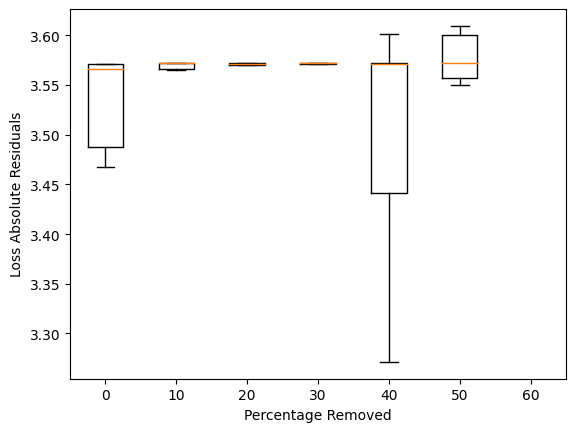

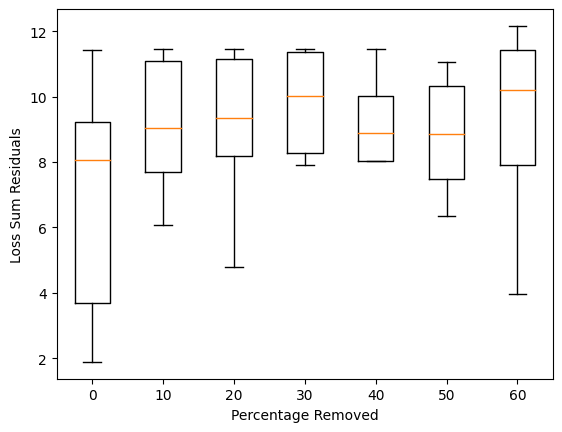

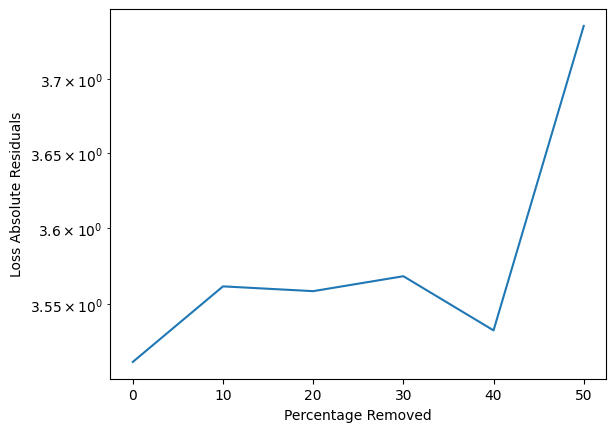

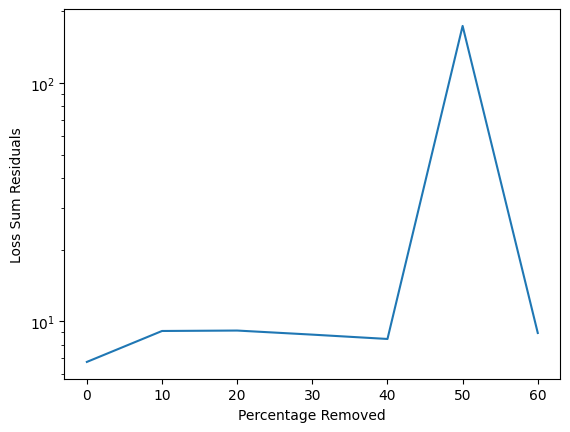

           Method        Optimization      Mean  Lower Bound  Upper Bound
0   Remove Random  Absolute Residuals  3.512329     3.445644     3.579015
10  Remove Random  Absolute Residuals  3.561516     3.497167     3.625865
20  Remove Random  Absolute Residuals  3.558385     3.534668     3.582102
30  Remove Random  Absolute Residuals  3.568181     3.449031     3.687331
40  Remove Random  Absolute Residuals  3.532775     3.420337     3.645213
50  Remove Random  Absolute Residuals  3.736426     3.431241     4.041611
60  Remove Random  Absolute Residuals       NaN          NaN          NaN
           Method   Optimization        Mean  Lower Bound  Upper Bound
0   Remove Random  Sum Residuals    6.761096     4.280108     9.242085
10  Remove Random  Sum Residuals    9.118034     7.639785    10.596283
20  Remove Random  Sum Residuals    9.156049     7.586660    10.725438
30  Remove Random  Sum Residuals    8.801782     6.280576    11.322987
40  Remove Random  Sum Residuals    8.440666     6.47

In [225]:
a = 'Absolute Residuals'
s = 'Sum Residuals'
r = 'Remove Random'

plot_box_dict(dict_abs2, a)
plot_box_dict(dict_sum2, s)
df_abs2 = plot_dict(dict_abs2, a, r)
df_sum2 = plot_dict(dict_sum2, s, r)

print(df_abs2)
print(df_sum2)

In [229]:
c = 'Combine'

mean = np.mean(dict_abs2_combine)
ci =stat.t.interval(confidence=0.95, df=len(dict_abs2_combine)-1, loc=mean, scale=stat.sem(dict_abs2_combine))
lower = ci[0]
upper = ci[1]
data1 = {'Method': c, 'Optimization': a, 'Mean': mean, 'Lower Bound': lower, 'Upper Bound': upper}
df_abs2_combine = pd.DataFrame(data1, columns=['Method','Optimization', 'Mean', 'Lower Bound', 'Upper Bound'], index=['40+60'])

mean = np.mean(dict_sum2_combine)
ci =stat.t.interval(confidence=0.95, df=len(dict_sum2_combine)-1, loc=mean, scale=stat.sem(dict_sum2_combine))
lower = ci[0]
upper = ci[1]
data2 = {'Method':c, 'Optimization': s, 'Mean': mean, 'Lower Bound': lower, 'Upper Bound': upper}
df_sum2_combine = pd.DataFrame(data2, columns=['Method','Optimization', 'Mean', 'Lower Bound', 'Upper Bound'], index=['40+60'])

print(df_abs2_combine)
print(df_sum2_combine)

        Method        Optimization         Mean  Lower Bound   Upper Bound
40+60  Combine  Absolute Residuals  3473.060027 -4375.608898  11321.728952
        Method   Optimization     Mean  Lower Bound  Upper Bound
40+60  Combine  Sum Residuals  9.49514     7.510869     11.47941


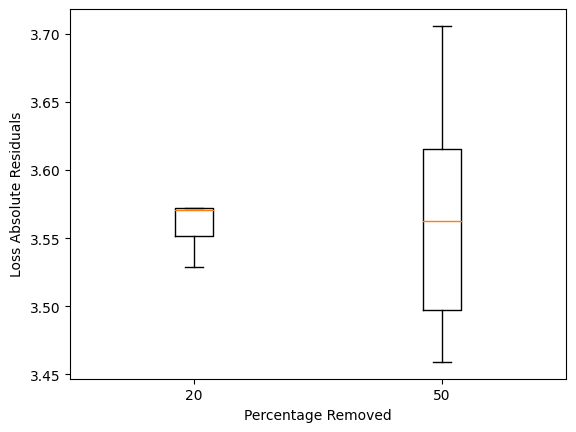

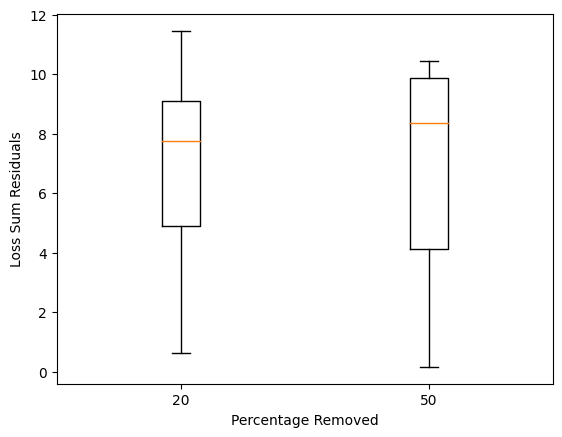

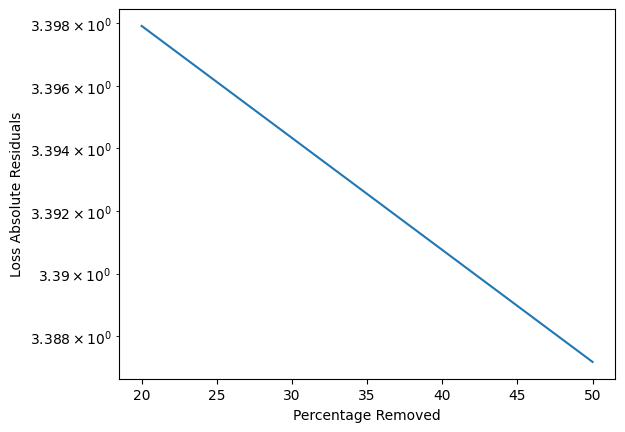

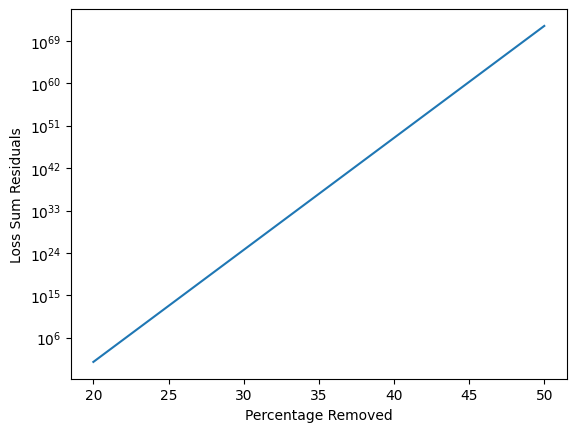

         Method        Optimization      Mean  Lower Bound  Upper Bound
20  Remove Last  Absolute Residuals  3.397916     2.804341     3.991492
50  Remove Last  Absolute Residuals  3.387181     2.949649     3.824712
         Method   Optimization          Mean   Lower Bound   Upper Bound
20  Remove Last  Sum Residuals  6.850970e+00  4.462317e+00  9.239624e+00
50  Remove Last  Sum Residuals  1.655591e+72 -2.089616e+72  5.400798e+72


In [230]:
l = "Remove Last"
plot_box_dict(dict_abs2_specific, a)
plot_box_dict(dict_sum2_specific, s)
df_abs2_specific = plot_dict(dict_abs2_specific, a, l)
df_sum2_specific = plot_dict(dict_sum2_specific, s, l)

print(df_abs2_specific)
print(df_sum2_specific)

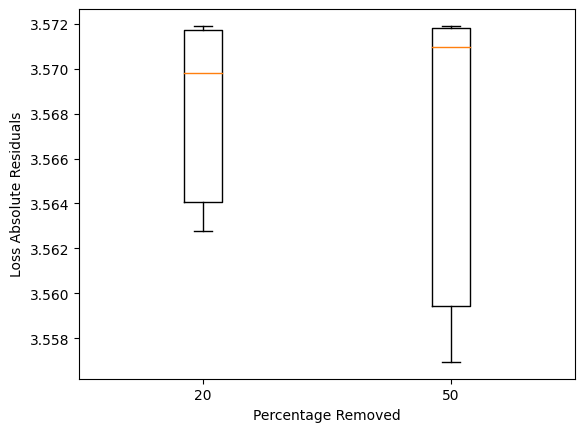

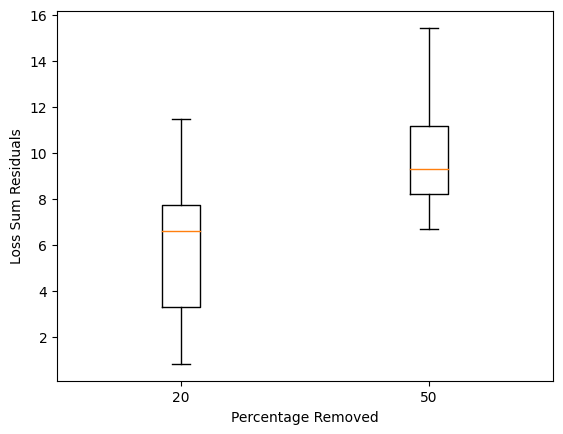

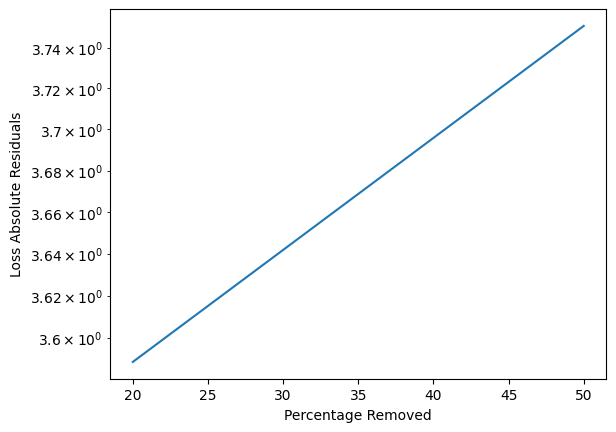

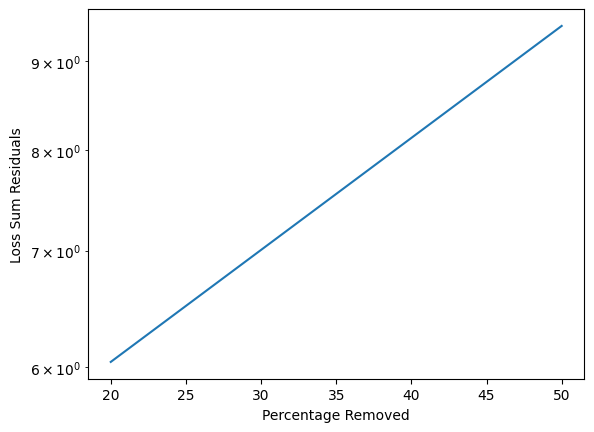

In [231]:
p = 'Peaks Predator'
plot_box_dict(dict_abs2_peaks,a)
plot_box_dict(dict_sum2_peaks,s)
df_abs2_peaks = plot_dict(dict_abs2_peaks,a, p)
df_sum2_peaks = plot_dict(dict_sum2_peaks,s, p)

In [266]:
df_losses2 = pd.concat([df_abs2,df_sum2,df_abs2_combine,df_sum2_combine,df_abs2_specific,df_sum2_specific,df_abs2_peaks ,df_sum2_peaks ], ignore_index=False)
# df_losses.to_csv('timeseries_ci.csv')
df = df_losses2
df

,Method,Optimization,Mean,Lower Bound,Upper Bound
0,Remove Random,Absolute Residuals,3.512329e+00,3.445644e+00,3.579015e+00
10,Remove Random,Absolute Residuals,3.561516e+00,3.497167e+00,3.625865e+00
20,Remove Random,Absolute Residuals,3.558385e+00,3.534668e+00,3.582102e+00
30,Remove Random,Absolute Residuals,3.568181e+00,3.449031e+00,3.687331e+00
40,Remove Random,Absolute Residuals,3.532775e+00,3.420337e+00,3.645213e+00
50,Remove Random,Absolute Residuals,3.736426e+00,3.431241e+00,4.041611e+00
60,Remove Random,Absolute Residuals,NaN,NaN,NaN
0,Remove Random,Sum Residuals,6.761096e+00,4.280108e+00,9.242085e+00
10,Remove Random,Sum Residuals,9.118034e+00,7.639785e+00,1.059628e+01
20,Remove Random,Sum Residuals,9.156049e+00,7.586660e+00,1.072544e+01


### Statistical Tests

In [92]:
# dict_abs
# dict_sum
list_abs_combine = [692.584575794109,
 68.1418395240675,
 146.42302623128361,
 138.28985765539403,
 744.5096571927884,
 252.5362669539149,
 794.3176536333037,
 753.054850292975,
 759.9508785405942,
 471.9727286000342,
 82.75254875795422,
 184.36231721479433,
 733.8414355289435,
 741.4465753406826,
 753.5512116938119,
 3.669614500929367e+16,
 301.68819997018454,
 743.6555882967856,
 743.3611605951646,
 401.0878629572017,
 786.651884533177,
 216.06059047958976,
 1027.1245590677486,
 1658.2742886097874,
 929.6858079097758,
 6.989548680936379e+151,
 167.7309573140569,
 745.3650482010282,
 754.7591509227292,
 766.3232587649981,
 246.62782961260112,
 1585.8208298585228,
 756.595044726009,
 93.92345823785877,
 754.152690757534,
 149.32511947807063,
 163.42394909011009,
 750.0255058565333,
 723.5034996892165,
 768.9979993356668,
 152.49069382151725,
 736.9051400171793,
 1362.9651725475921,
 105.4696240433879,
 750.3890620883784,
 197.42341440106736,
 711.4709723166981,
 238.67670290581887,
 1050.3275536144306,
 314.5082981935572,
 747.2356466375003,
 272.51385371403234,
 215.09175931724926,
 621.2475682226406,
 343.4598040692798,
 139.12351129707966,
 742.638811908864,
 166.33791481680663,
 139.27397821560882,
 780.6241418233476,
 266.7869936935682,
 753.1984293272327,
 757.7193690361189,
 38.57057422105619,
 341.53692946613313,
 763.8178248775037,
 760.0454963674193,
 760.6059626163765,
 171.0612056279138,
 157.73672101718287,
 704.5619402899536,
 586.6824876483836,
 754.4150619928455,
 752.6589303826786,
 188.02446209125742,
 884.4301506439099,
 725.0293899958738,
 823.4850259573108,
 755.1080338231905,
 657.5475760209335,
 778.0269584301682,
 762.1248601386127,
 755.3935344101179,
 750.3083850678488,
 86.76851534467913,
 751.0828019145483,
 232.0800490792483,
 883.8383132216644,
 380.9964110261664,
 718.3291158046171,
 756.3845707405344,
 1.5508500985389843e+17,
 202.55453509138775,
 774.7835339175427,
 745.5513866917977,
 748.1015678838953,
 90.14929736098357,
 757.0334465718149,
 77.95074363013538,
 768.8526770820555]
list_sum_combine = [734.1741905050108,
 971.6072090039678,
 900.6786418576321,
 792.2737567824626,
 99.91643612182041,
 26747597.3790165,
 209.98633593245745,
 1088.8442086371367,
 687.4075042970326,
 755.1097205205368,
 639.0580428666568,
 799.7385480379552,
 735.8696980110724,
 748.9402811180009,
 199.2915677137065,
 731.4727300478016,
 750.4723993120442,
 756.0639489475184,
 668.0455793392422,
 1058.093318535606,
 767.8855040870063,
 195.07797820124188,
 776.8186360240643,
 28.409284873925905,
 194.80702374900392,
 749.9434696127354,
 252.93994955354412,
 750.0330347538194,
 885.9088342048018,
 741.4856953038014,
 736.1694077392007,
 749.5130486733415,
 1091.339202938288,
 254.20350922351034,
 878.3980874032706,
 752.6009740953285,
 831.4807319592211,
 788.6540982158135,
 752.5238779129094,
 591.830749391971,
 229.4133024628477,
 707.1543845386956,
 748.5794241785769,
 752.0538200774555,
 756.0491393579264,
 382.48696327154926,
 676.9611981686961,
 274.08683409249255,
 24.5958463724006,
 152.1271071300761,
 752.8740600939877,
 103.50496972717664,
 196.04021861025493,
 874.5549027158949,
 735.0646199943949,
 112.99622301359571,
 345.4989573440447,
 751.17640680243,
 3382.6529023923363,
 880.8985920845796,
 136.17554865775347,
 128.43755976814077,
 882.9918508790455,
 743.2269926967546,
 346.8427798234635,
 744.5564706277473,
 334.55464612896475,
 106.92798979211732,
 753.0042445438119,
 927.2509956494375,
 9818871587386.463,
 289.56821227148123,
 752.4291297930437,
 1191.680809376029,
 2681.41062416362,
 751.2971472243481,
 865.0901848186085,
 750.8720294713474,
 287.5125944602399,
 943.4348020902411,
 222.97517328867448,
 695.6503054786591,
 707.2374781556058,
 757.7091554125199,
 199.45754779003852,
 658.1720118340563,
 756.7508635850136,
 113.86933428571437,
 751.3691736716117,
 875.9107531587297,
 752.2726332505944,
 95.37424899605791,
 1.158401271936356e+41,
 766.3989800567957,
 747.6174268695574,
 765.9059351978259,
 872.0246774087233,
 197.6209026318638,
 91.92734359391329,
 2258.5571406643157]
# dict_abs_specific
# dict_sum_specific
# dict_abs_peaks 
# dict_sum_peaks



In [237]:
# Select rows where the index is '20' or '50'
selected_rows = df[df.index.isin([20, 50])]
df = selected_rows
df["index"] = df.index

df


C:\Users\Esthe\AppData\Local\Temp\ipykernel_18508\635064429.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["index"] = df.index


,Method,Optimization,Mean,Lower Bound,Upper Bound,index
20,Remove Random,Absolute Residuals,3.558385e+00,3.534668e+00,3.582102e+00,20
50,Remove Random,Absolute Residuals,3.736426e+00,3.431241e+00,4.041611e+00,50
20,Remove Random,Sum Residuals,9.156049e+00,7.586660e+00,1.072544e+01,20
50,Remove Random,Sum Residuals,1.739298e+02,-1.999313e+02,5.477909e+02,50
20,Remove Last,Absolute Residuals,3.397916e+00,2.804341e+00,3.991492e+00,20
50,Remove Last,Absolute Residuals,3.387181e+00,2.949649e+00,3.824712e+00,50
20,Remove Last,Sum Residuals,6.850970e+00,4.462317e+00,9.239624e+00,20
50,Remove Last,Sum Residuals,1.655591e+72,-2.089616e+72,5.400798e+72,50
20,Peaks Predator,Absolute Residuals,3.588545e+00,3.531896e+00,3.645195e+00,20
50,Peaks Predator,Absolute Residuals,3.750698e+00,3.261675e+00,4.239722e+00,50


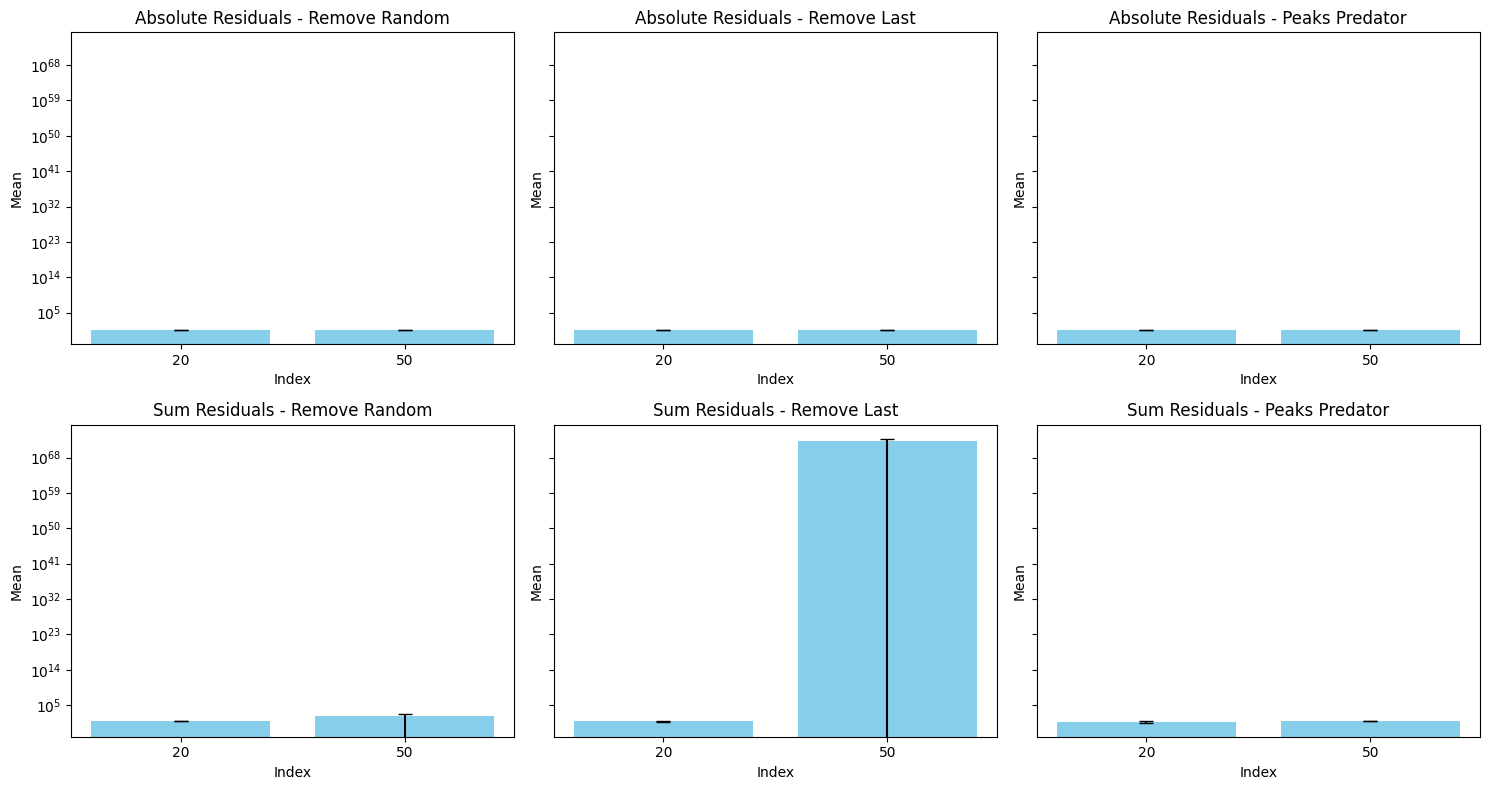

In [238]:
# Filter the DataFrame for the specified groups and methods
filtered_df = df[(df['Optimization'].isin(['Absolute Residuals', 'Sum Residuals'])) & (df['Method'].isin(['Remove Random', 'Remove Last', 'Peaks Predator']))]

# Plotting
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 8), sharey=True)

methods = filtered_df['Method'].unique()
groups = filtered_df['Optimization'].unique()

for i, group in enumerate(groups):
    for j, method in enumerate(methods):
        ax = axes[i, j]
        subset = filtered_df[(filtered_df['Optimization'] == group) & (filtered_df['Method'] == method)]
        yerr = [subset['Mean'] - subset['Lower Bound'], subset['Upper Bound'] - subset['Mean']]
        ax.bar(subset['index'].astype(str), subset['Mean'], yerr=yerr, capsize=5, color='skyblue', label='Mean')
        ax.set_title(f'{group} - {method}')
        ax.set_ylabel('Mean')
        ax.set_xlabel('Index')
        ax.set_yscale('log')  # Set y-axis to log scale

plt.tight_layout()
plt.show()


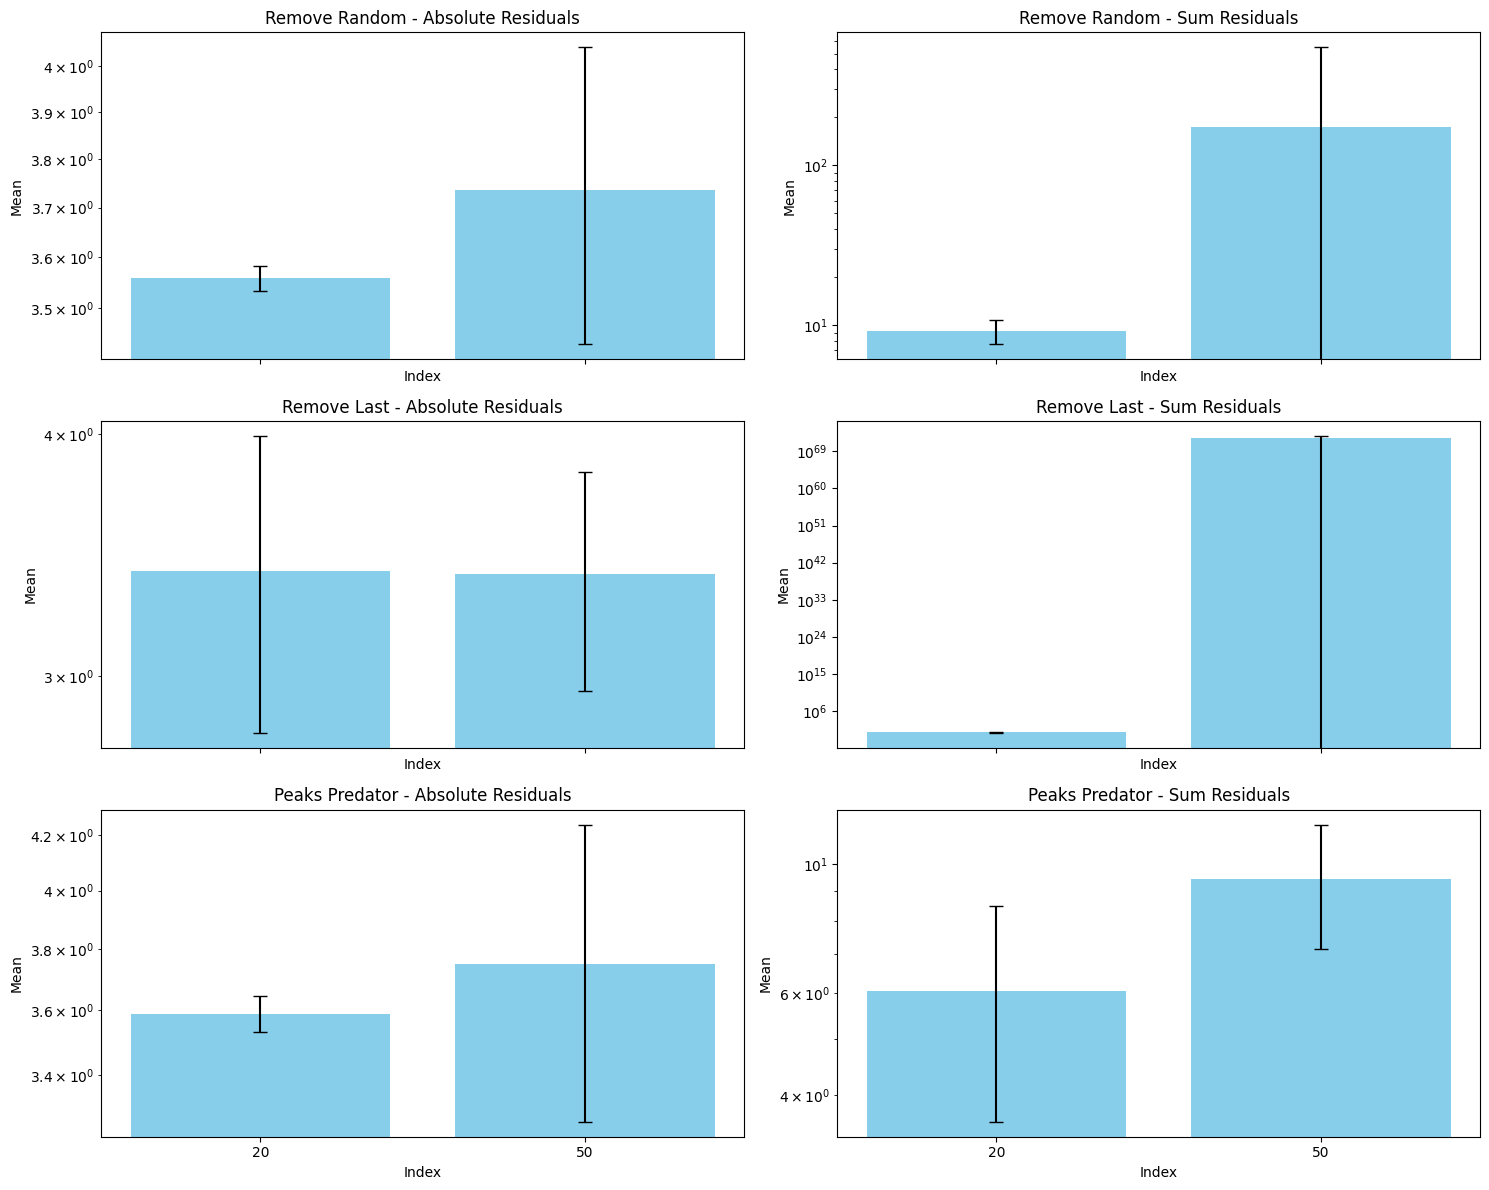

In [239]:
# Filter the DataFrame for the specified groups and methods
filtered_df = df[(df['Optimization'].isin(['Absolute Residuals', 'Sum Residuals'])) & (df['Method'].isin(['Remove Random', 'Remove Last', 'Peaks Predator']))]

# Plotting
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12), sharex=True)

methods = filtered_df['Method'].unique()
groups = filtered_df['Optimization'].unique()

for i, method in enumerate(methods):
    for j, group in enumerate(groups):
        ax = axes[i, j]
        subset = filtered_df[(filtered_df['Optimization'] == group) & (filtered_df['Method'] == method)]
        yerr = [subset['Mean'] - subset['Lower Bound'], subset['Upper Bound'] - subset['Mean']]
        ax.bar(subset['index'].astype(str), subset['Mean'], yerr=yerr, capsize=5, color='skyblue', label='Mean')
        ax.set_title(f'{method} - {group}')
        ax.set_xlabel('Index')
        ax.set_ylabel('Mean')
        ax.set_yscale('log')  # Set y-axis to log scale



plt.tight_layout()
plt.show()



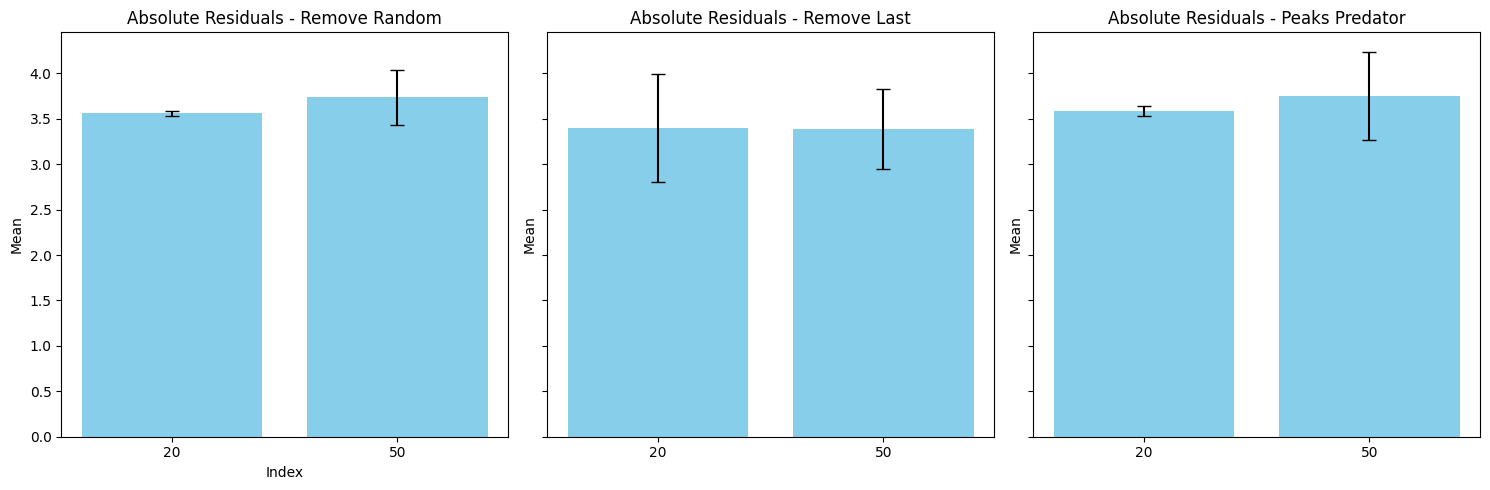

In [241]:
# Filter the DataFrame for Absolute Residuals and all three methods
filtered_df = df[(df['Optimization'] == 'Absolute Residuals') & (df['Method'].isin(['Remove Random', 'Remove Last', 'Peaks Predator']))]

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

methods = filtered_df['Method'].unique()

for i, method in enumerate(methods):
    ax = axes[i]
    subset = filtered_df[filtered_df['Method'] == method]
    yerr = [subset['Mean'] - subset['Lower Bound'], subset['Upper Bound'] - subset['Mean']]
    ax.bar(subset['index'].astype(str), subset['Mean'], yerr=yerr, capsize=5, color='skyblue', label='Mean')
    ax.set_title(f'Absolute Residuals - {method}')
    ax.set_ylabel('Mean')
    # ax.set_yscale('log')  # Set y-axis to log scale

# Set common x-axis label
axes[0].set_xlabel('Index')
plt.tight_layout()
plt.show()


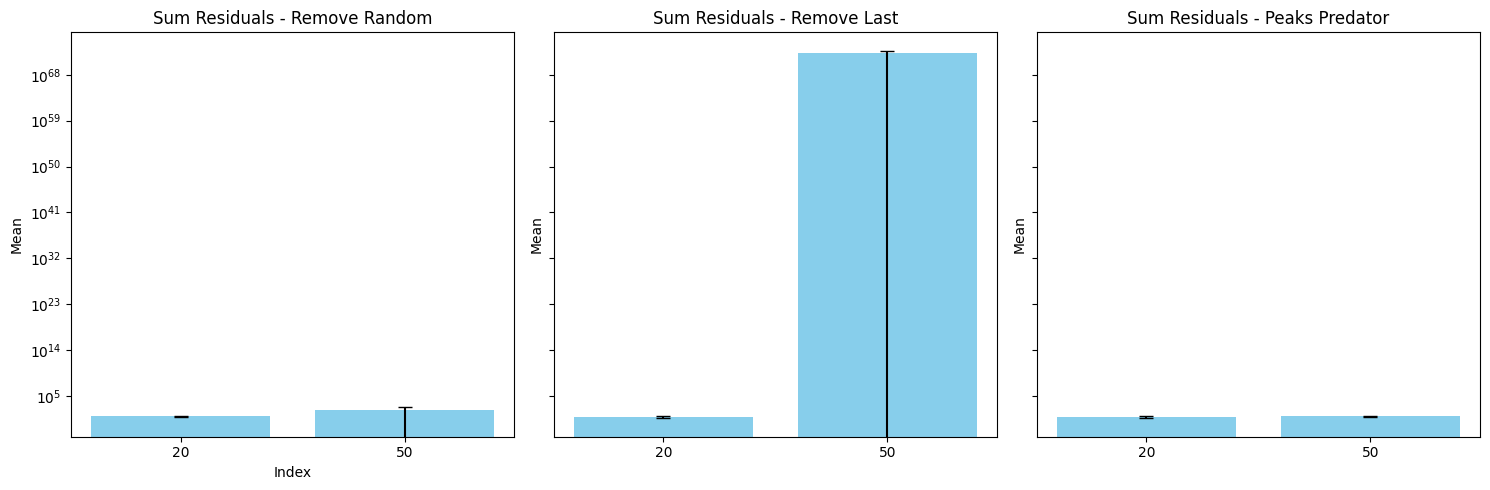

In [243]:
# Filter the DataFrame for Sum Residuals and all three methods
filtered_df = df[(df['Optimization'] == 'Sum Residuals') & (df['Method'].isin(['Remove Random', 'Remove Last', 'Peaks Predator']))]

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

methods = filtered_df['Method'].unique()

for i, method in enumerate(methods):
    ax = axes[i]
    subset = filtered_df[filtered_df['Method'] == method]
    yerr = [subset['Mean'] - subset['Lower Bound'], subset['Upper Bound'] - subset['Mean']]
    ax.bar(subset['index'].astype(str), subset['Mean'], yerr=yerr, capsize=5, color='skyblue', label='Mean')
    ax.set_title(f'Sum Residuals - {method}')
    ax.set_ylabel('Mean')
    ax.set_yscale('log')  # Set y-axis to log scale

# Set common x-axis label
axes[0].set_xlabel('Index')
plt.tight_layout()
plt.show()


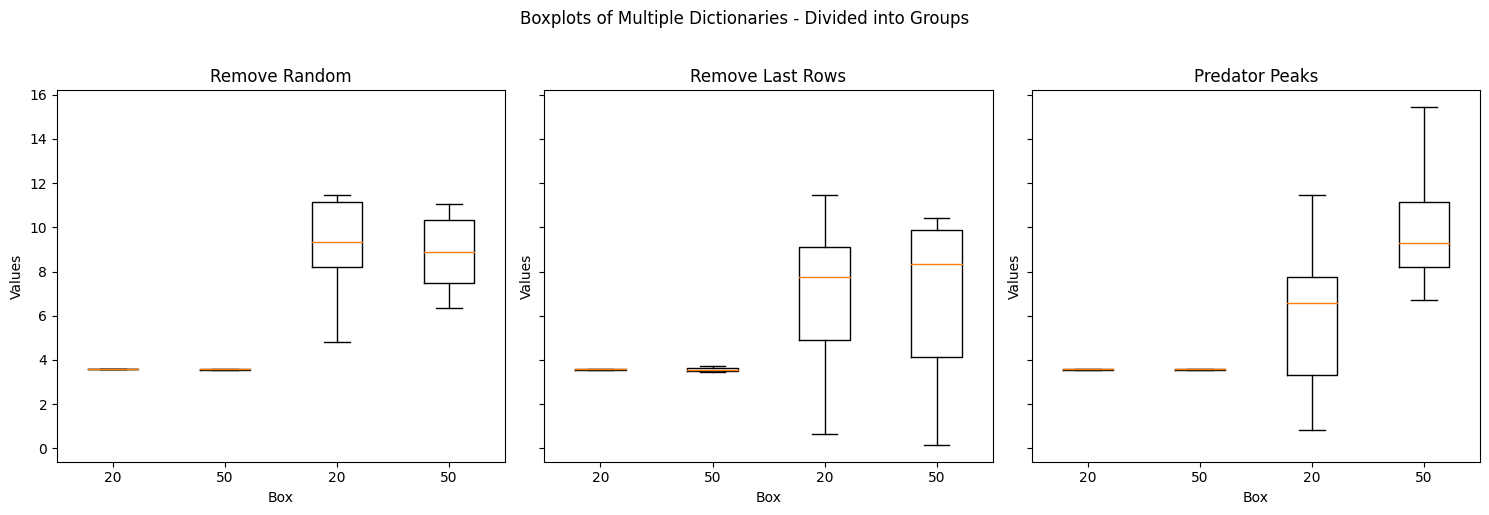

In [298]:
# plot_dict(open_dict('dict_sum_specific.csv'), a, r)

dict_abs[20]
# dict_sum = open_dict('dict_sum.csv') 

# dict_abs_combine # beneden
# dict_sum_combine # beneden 

# dict_abs_specific = open_dict('dict_abs_specific.csv') 
# dict_sum_specific = open_dict('dict_sum_specific.csv') 

# dict_abs_peaks = open_dict('dict_abs_peaks.csv') 
# dict_sum_peaks = open_dict('dict_sum_peaks.csv') 

import matplotlib.pyplot as plt

# Example data (replace with your actual data)
data0 = dict_abs2[0]
data00 = dict_sum2[0]
data1 = dict_abs2[20]
data2 = dict_abs2[50]
data3 = dict_sum2[20]
data4 = dict_sum2[50]
data5 = dict_abs2_specific[20]
data6 = dict_abs2_specific[50]
data7 = dict_sum2_specific[20]
data8 = dict_sum2_specific[50]
data9 = dict_abs2_peaks[20]
data10 = dict_abs2_peaks[50]
data11 = dict_sum2_peaks[20]
data12= dict_sum2_peaks[50]

group1 = [data1, data2, data3, data4]
group2 = [data5, data6, data7, data8]
group3 = [data9, data10, data11, data12]

groups = ['Remove Random', 'Remove Last Rows', 'Predator Peaks']

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5), sharey=True)

for i, group in enumerate([group1, group2, group3]):
    ax = axes[i]
    ax.boxplot(group, labels=['20', '50', '20', '50'], showfliers=False)
    ax.set_title(groups[i])
    ax.set_xlabel('Box')
    ax.set_ylabel('Values')

plt.suptitle('Boxplots of Multiple Dictionaries - Divided into Groups', y=1.02)
plt.tight_layout()
plt.show()


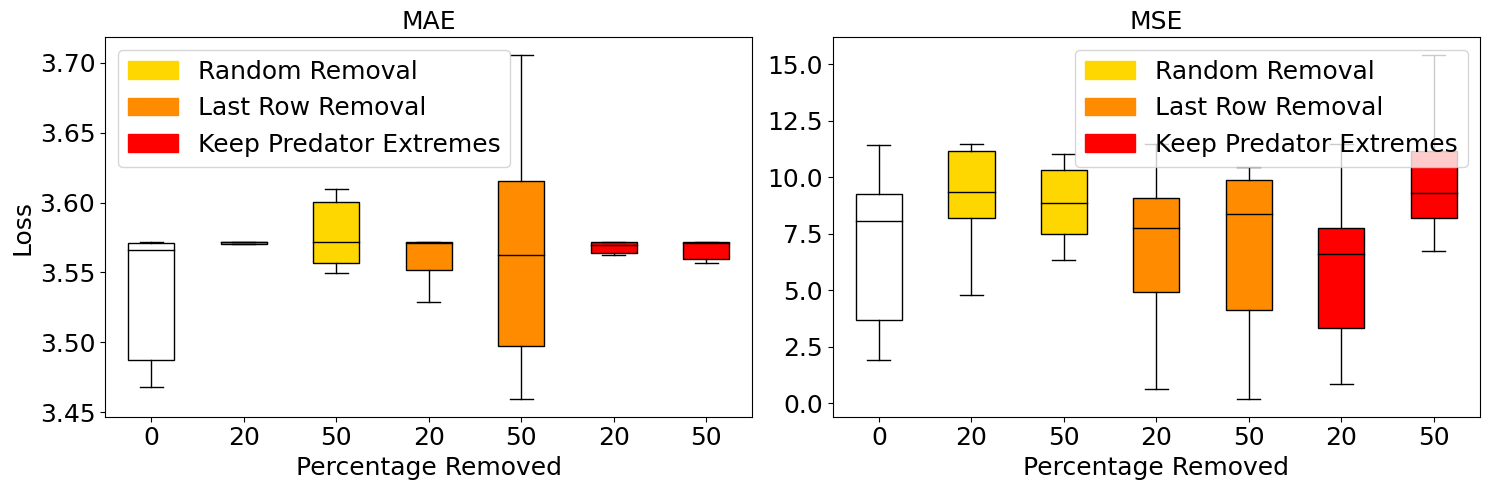

In [301]:
# plot_dict(open_dict('dict_sum_specific.csv'), a, r)
import matplotlib.patches as mpatches
dict_abs[20]
# dict_sum = open_dict('dict_sum.csv') 

# dict_abs_combine # beneden
# dict_sum_combine # beneden 

# dict_abs_specific = open_dict('dict_abs_specific.csv') 
# dict_sum_specific = open_dict('dict_sum_specific.csv') 

# dict_abs_peaks = open_dict('dict_abs_peaks.csv') 
# dict_sum_peaks = open_dict('dict_sum_peaks.csv') 

import matplotlib.pyplot as plt

# Example data (replace with your actual data)

data0 = dict_abs2[0]
data00 = dict_sum2[0]

group1 = [data0, data1, data2, data5, data6, data9, data10]

group2 = [data00, data3, data4,data7, data8,   data11, data12]
          
          

                

groups = ['MAE', 'MSE']

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=False)

for i, group in enumerate([group1, group2]):
    ax = axes[i]
    bp = ax.boxplot(group, labels=['0','20', '50', '20', '50', '20', '50'], showfliers=False, patch_artist=True)
    # Set boxplot colors
    colors = ['white','gold','gold','darkorange', 'darkorange', 'red', 'red']
    for box, color in zip(bp['boxes'], colors):
        box.set_facecolor(color)

    # Add legend
    legend_labels = ['Random Removal', 'Last Row Removal', 'Keep Predator Extremes']
    legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(['gold', 'darkorange', 'red'], legend_labels)]
    ax.legend(handles=legend_handles, fontsize = 18)

    for median in bp['medians']:
        median.set(color='black')

    ax.tick_params(labelsize = 18)

    ax.set_title(groups[i], fontsize = 18)
    ax.set_xlabel('Percentage Removed', fontsize = 18)
    if i == 0:
        ax.set_ylabel('Loss', fontsize = 18)



plt.tight_layout()
plt.show()

count = [2, 14, 3, 9, 1, 1, 0, 2, 0, 14, 1, 12]
outlier = [2, 3, 2, 1, 3, 3, 0, 1, 0, 1, 0, 1]

In [256]:
import numpy as np


def outliers(data):
    # Convert the list to a NumPy array for convenience
    data_array = np.array(data)

    # Calculate the first and third quartiles (Q1 and Q3)
    Q1 = np.percentile(data_array, 25)
    Q3 = np.percentile(data_array, 75)

    # Calculate the interquartile range (IQR)
    IQR = Q3 - Q1

    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers
    outliers = [value for value in data_array if value < lower_bound or value > upper_bound]

    # Count the number of outliers
    count_outliers = len(outliers)

    return count_outliers


data_list = [data1, data2, data3, data4, data5, data6, data7, data8, data9, data10, data11, data12]
data_list = [data1, data2, data5, data6, data9, data10, data3, data4,data7, data8,   data11, data12]


count_list = []
for data in data_list:
    count = outliers(data)
    count_list.append(count)

count_list 

[2, 3, 2, 1, 3, 3, 0, 1, 0, 1, 0, 1]

In [316]:
# One-tailed Welch's test to comparee the waiting time for different values of n
def welchs_test(waiting_times_1, waiting_times_2):
    test = stat.ttest_ind(waiting_times_1,waiting_times_2, equal_var=False)
    statistic = test.statistic
    pvalue = test.pvalue
    df = test.df
    if pvalue <=0.05:
        return statistic, pvalue, df, 'significant'
    return statistic, pvalue, df 

data0 = dict_abs2[0]
data00 = dict_sum2[0]
data1 = dict_abs2[20]
data2 = dict_abs2[50]
data3 = dict_sum2[20]
data4 = dict_sum2[50]
data5 = dict_abs2_specific[20]
data6 = dict_abs2_specific[50]
data7 = dict_sum2_specific[20]
data8 = dict_sum2_specific[50]
data9 = dict_abs2_peaks[20]
data10 = dict_abs2_peaks[50]
data11 = dict_sum2_peaks[20]
data12= dict_sum2_peaks[50]

print("between percentage 20 and 50: statistic, pvalue, df,")
print(f'MAE Random Removal and 10 runs: {welchs_test(dict_abs2[20],dict_abs2[50])}')
print(f'MAE Last Row Removal and 10 runs: {welchs_test(dict_abs2_specific[20],dict_abs2_specific[50])}')
print(f'MAE Keep Predator Extremes and 10 runs: {welchs_test(dict_abs2_peaks[20], dict_abs2_peaks[50])}')

print("between percentage 20 and 50: statistic, pvalue, df,")
print(f'MSE Random Removal and 10 runs: {welchs_test(dict_sum2[20],dict_sum2[50])}')
print(f'MSE Last Row Removal and 10 runs: {welchs_test(dict_sum2_specific[20],dict_sum2_specific[50])}')
print(f'MSE Keep Predator Extremes and 10 runs: {welchs_test(dict_sum2_peaks[20], dict_sum2_peaks[50])}')

print('20')
print(f'MAE rr s and 10 runs: {welchs_test(dict_abs2[20],dict_abs2_specific[20])}')
print(f'MAE rr p 10 runs: {welchs_test(dict_abs2[20],dict_abs2_peaks[20])}')
print(f'MAE s p 10 runs: {welchs_test(dict_abs2_specific[20], dict_abs2_peaks[20])}')
print('50')
print(f'MAE rr s and 10 runs: {welchs_test(dict_abs2[50],dict_abs2_specific[50])}')
print(f'MAE rr p 10 runs: {welchs_test(dict_abs2[50],dict_abs2_peaks[50])}')
print(f'MAE s p 10 runs: {welchs_test(dict_abs2_specific[50], dict_abs2_peaks[50])}')

print('20')
print(f'MSE rr s and 10 runs: {welchs_test(dict_sum2[20],dict_sum2_specific[20])}')
print(f'MSE rr p 10 runs: {welchs_test(dict_sum2[20],dict_sum2_peaks[20])}')
print(f'MSE s p 10 runs: {welchs_test(dict_sum2_specific[20], dict_sum2_peaks[20])}')
print('50')
print(f'MSE rr s and 10 runs: {welchs_test(dict_sum2[50],dict_sum2_specific[50])}')
print(f'MSE rr p 10 runs: {welchs_test(dict_sum2[50],dict_sum2_peaks[50])}')
print(f'MSE s p 10 runs: {welchs_test(dict_sum2_specific[50], dict_sum2_peaks[50])}')

print('compare with 0 - 20')
print("between percentage 0 and 20: statistic, pvalue, df,")
print(f'MAE Random Removal and 10 runs: {welchs_test(data0,dict_abs2[20])}')
print(f'MAE Last Row Removal and 10 runs: {welchs_test(data0,dict_abs2_specific[20])}')
print(f'MAE Keep Predator Extremes and 10 runs: {welchs_test(data0, dict_abs2_peaks[20])}')

print("between percentage 0 and 20: statistic, pvalue, df,")
print(f'MSE Random Removal and 10 runs: {welchs_test(data00,dict_sum2[20])}')
print(f'MSE Last Row Removal and 10 runs: {welchs_test(data00,dict_sum2_specific[20])}')
print(f'MSE Keep Predator Extremes and 10 runs: {welchs_test(data00, dict_sum2_peaks[20])}')

print('compare with 0 - 50')
print("between percentage 0 and 50: statistic, pvalue, df,")
print(f'MAE Random Removal and 10 runs: {welchs_test(data0,dict_abs2[50])}')
print(f'MAE Last Row Removal and 10 runs: {welchs_test(data0,dict_abs2_specific[50])}')
print(f'MAE Keep Predator Extremes and 10 runs: {welchs_test(data0, dict_abs2_peaks[50])}')

print("between percentage 0 and 50: statistic, pvalue, df,")
print(f'MSE Random Removal and 10 runs: {welchs_test(data00,dict_sum2[50])}')
print(f'MSE Last Row Removal and 10 runs: {welchs_test(data00,dict_sum2_specific[50])}')
print(f'MSE Keep Predator Extremes and 10 runs: {welchs_test(data00, dict_sum2_peaks[50])}')

between percentage 20 and 50: statistic, pvalue, df,
MAE Random Removal and 10 runs: (-1.3157435686207495, 0.2204112268210635, 9.108705169471333)
MAE Last Row Removal and 10 runs: (0.032933877215267714, 0.9741212275995661, 16.550902044958782)
MAE Keep Predator Extremes and 10 runs: (-0.7451155113567208, 0.4747244719650643, 9.241506427985275)
between percentage 20 and 50: statistic, pvalue, df,
MSE Random Removal and 10 runs: (-0.9970037237858609, 0.34481064059270006, 9.000317185498684)
MSE Last Row Removal and 10 runs: (-0.9999999999999999, 0.34343639613791355, 9.0)
MSE Keep Predator Extremes and 10 runs: (-2.2957903836528413, 0.03397593361062332, 17.916536259958963, 'significant')
20
MAE rr s and 10 runs: (0.6110691777961305, 0.5562234247040787, 9.028736909456594)
MAE rr p 10 runs: (-1.1109455262532368, 0.2882484743856407, 12.060955607090532)
MAE s p 10 runs: (-0.7232140202517126, 0.48759627570459396, 9.163937754267803)
50
MAE rr s and 10 runs: (1.4810056935218876, 0.15793197352059485

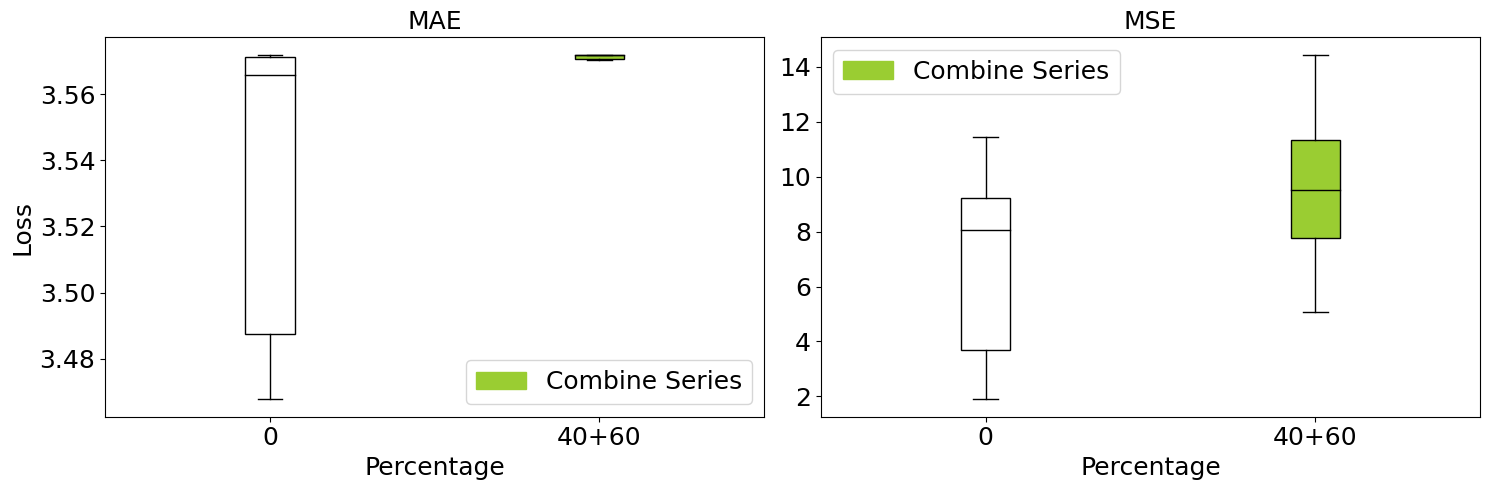

In [305]:
# Data
group1 = [dict_abs2[0], dict_abs2_combine]
group2 = [dict_sum2[0], dict_sum2_combine]
labels = ['0', '40+60']

groups = ['MAE', 'MSE']

# Plotting
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), sharey=False)

for i, group in enumerate([group1, group2]):
    ax = axes[i]
    bp = ax.boxplot(group, labels=labels, showfliers=False, patch_artist=True)
    # Set boxplot colors
    colors = ['white','yellowgreen']
    for box, color in zip(bp['boxes'], colors):
        box.set_facecolor(color)

    # Add legend
    legend_labels = ['Combine Series']
    legend_handles = [mpatches.Patch(color=color, label=label) for color, label in zip(['yellowgreen'], legend_labels)]
    ax.legend(handles=legend_handles, fontsize = 18)

    for median in bp['medians']:
        median.set(color='black')

    ax.tick_params(labelsize = 18)

    ax.set_title(groups[i], fontsize = 18)
    ax.set_xlabel('Percentage', fontsize = 18)
    if i == 0:
        ax.set_ylabel('Loss', fontsize = 18)



plt.tight_layout()
plt.show()


In [294]:
def welchs_test(waiting_times_1, waiting_times_2):
    test = stat.ttest_ind(waiting_times_1,waiting_times_2, equal_var=False)
    statistic = test.statistic
    pvalue = test.pvalue
    df = test.df
    return statistic, pvalue, df 

print("between percentage 20 and 50: statistic, pvalue, df,")
print(f'MAE Random Removal and 10 runs: {welchs_test(dict_abs2[0], dict_abs2_combine)}')

print(f'MSE Keep Predator Extremes and 10 runs: {welchs_test(dict_sum2[0], dict_sum2_combine)}')

between percentage 20 and 50: statistic, pvalue, df,
MAE Random Removal and 10 runs: (-0.9999991401082583, 0.3434367901896733, 9.000000001299396)
MSE Keep Predator Extremes and 10 runs: (-1.9468202138245865, 0.06810476863619497, 17.170735052512455)
